### Standardizing Model Evaluations
Assumptions made in order for these functions to work:
*   Scores will be stored into a csv file
*   Plots will take scores from csv file

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

### Data

In [58]:
yolo_training_log_directory = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\model_outputs\Yolov8_Training_Log.csv" 
deit_training_log_directory = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\model_outputs\deit_training_log\deit_training_log_v4.csv"

In [59]:
yolo_validation_results_directory = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\model_outputs\Yolov8_Validation_Results_Raw.csv"
deit_validation_results_directory = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\model_outputs\deit_validation_results\validation_results_v4.csv"

### Transform CSV to Pandas Dataframes

In [60]:
# define function to save scores and number of epochs to pandas dataframe for each model's training log
def save_scores_to_df(directory, epochs, train_loss, val_loss, val_accuracy_top1, val_accuracy_top5):
    '''
    stores train and validation loss and accuracy into a pandas dataframe
    '''
    # read in csv 
    df = pd.read_csv(directory)
    
    # create a dictionary to store the scores
    scores = {
        'Epoch': df[epochs],
        'Train Loss': df[train_loss],
        'Val Loss': df[val_loss],
        'Val Accuracy Top 1': df[val_accuracy_top1], 
        'Val Accuracy Top 5': df[val_accuracy_top5] 
    }

    # convert the dictionary to a DataFrame
    df = pd.DataFrame(scores)
    return df 

# call function
deit_training_log_df = save_scores_to_df(deit_training_log_directory, 'Epoch', 'Train/Loss', 'Val/Loss', 
                      'Val_Metrics/Accuracy_Top1',	'Val_Metrics/Accuracy_Top5') 
yolo_training_log_df = save_scores_to_df(yolo_training_log_directory, 'epoch', 'train/loss', 'val/loss', 
                               'metrics/accuracy_top1', 'metrics/accuracy_top5') 

In [62]:
# define a function to save validation results into a pandas dataframe
def save_validation_results_to_df(directory, img_name, predicted_class, true_class, confidence_value): 
    # read in csv
    df = pd.read_csv(directory) 
    
    # create a dictionary to store the validation results 
    validation_results = {
        'Image Name': df[img_name], 
        # 'Predicted Label': df[predicted_label], 
        # 'True Label': df[true_label], 
        'Predicted Class': df[predicted_class], 
        'True Class': df[true_class], 
        'Confidence Value': df[confidence_value] 
    }
    
    # convert dictionary to a DataFrame
    df = pd.DataFrame(validation_results)
    return df 

# call function 
yolo_val_results_df = save_validation_results_to_df(yolo_validation_results_directory, 'img_name', 
                                                    'most_confident_label', 'class_name', 
                                                    'most_confident_value') 
deit_val_results_df = save_validation_results_to_df(deit_validation_results_directory, 'img_name',
                                                    'predicted_class', 'true_class', 
                                                    'confidence') 

In [64]:
# define a function to save Summary Metrics into a pandas dataframe
def summary_metrics_to_df(df, model):
    df['True Label'] = pd.Categorical(df['True Class']).codes
    df['Predicted Label'] = pd.Categorical(df['Predicted Class']).codes

    # auc roc score
    lb = LabelBinarizer()
    y_true = lb.fit_transform(df['True Label'])
    y_pred_proba = np.array([df['Confidence Value']]*y_true.shape[1]).T
    
    # Calculate the weighted AUC-ROC score
    auc_roc_weighted = roc_auc_score(y_true, y_pred_proba, average='weighted')

    # # CAN DELETE IF WE WANT: Calculate the roc_auc_score for each class
    # for i in range(y_true.shape[1]):
    #     auc_roc = roc_auc_score(y_true[:, i], validation_results_df['confidence'])
    #     print(f"AUC-ROC for class {i}: {auc_roc}")

    # Get the top 3 predicted labels
    top_3_predicted_labels = []
    for i in range(len(df['Confidence Value'])):
        top_3_indices = np.argsort(df['Confidence Value'].iloc[i])[-3:][::-1]
        top_3_predicted_labels.append(np.array([df['Predicted Label'].iloc[i]]))
    
    # Check if true label is in top 3 predicted labels
    correct_top_3 = [x in y for x, y in zip(df['True Label'], top_3_predicted_labels)]
    
    # Calculate the top 3 accuracy
    top_3_accuracy = np.mean(correct_top_3)
        
    summary_metrics = {
        'Accuracy': [accuracy_score(df['True Label'], df['Predicted Label'])],
        'Precision': [precision_score(df['True Label'], df['Predicted Label'], average='macro')],
       'Recall': [recall_score(df['True Label'], df['Predicted Label'], average='macro', zero_division=0)],
        'F1': [f1_score(df['True Label'], df['Predicted Label'], average='macro', zero_division=0)],
        'AUC-ROC': auc_roc_weighted, 
        'Top 3 Accuracy': top_3_accuracy
    }
    # convert the dictionary to a DataFrame
    df = pd.DataFrame(summary_metrics)
    df['model_name'] = model
    return df

# call function 
summary_metrics_df = pd.concat([summary_metrics_to_df(yolo_val_results_df, 'YOLOv8'), 
                                summary_metrics_to_df(deit_val_results_df, 'DeiT')]) 

### Evaluate Models

In [65]:
summary_metrics_df

,Accuracy,Precision,Recall,F1,AUC-ROC,Top 3 Accuracy,model_name
0,0.607284,0.626265,0.601267,0.598870,0.500075,0.607284,YOLOv8
0,0.439430,0.463761,0.439979,0.430095,0.499986,0.439430,DeiT


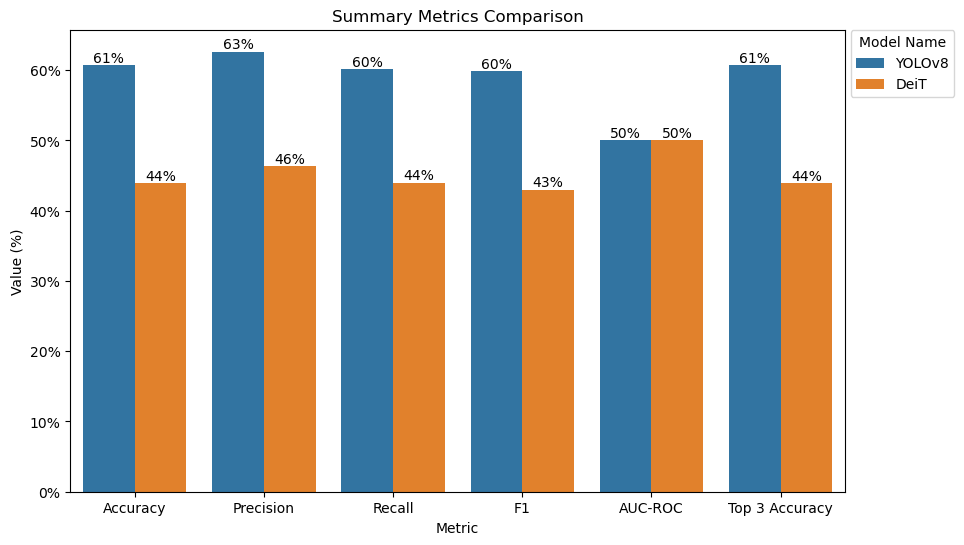

In [66]:
# Plots the Summary Metrics
# Melt the DataFrame to convert it into a long format
summary_metrics_df_melt = summary_metrics_df.melt(id_vars='model_name')

# Plot the summary metrics
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='variable', y='value', hue='model_name', data=summary_metrics_df_melt, ax=ax)
plt.title('Summary Metrics Comparison')
plt.xlabel('Metric')
plt.ylabel('Value (%)')
plt.legend(title='Model Name', loc='upper right', bbox_to_anchor=(1.15, 1.014))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x*100)))

# Add value labels to each bar
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), "{:.0f}%".format(p.get_height()*100), ha="center", va="bottom", color="black")

plt.show()

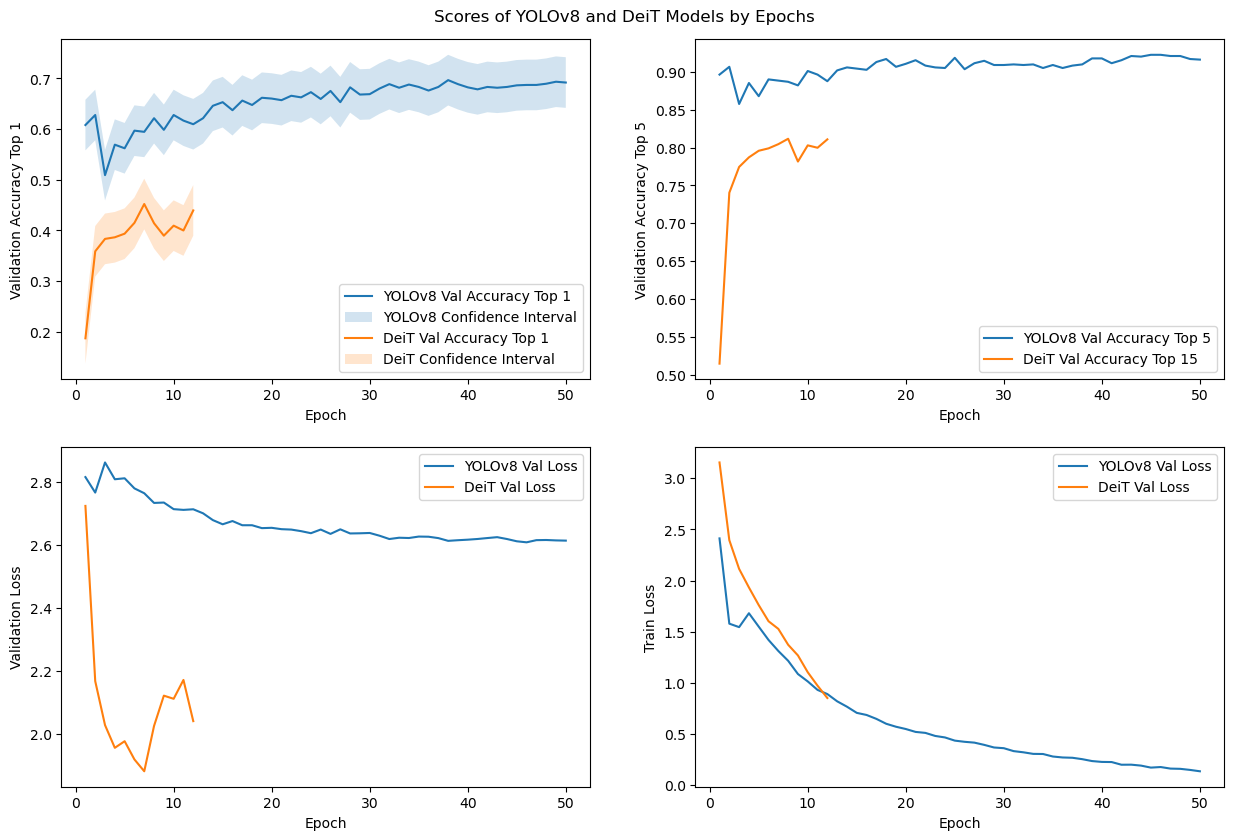

In [67]:
# Plots validation accuracy of each model against each other 
plt.figure(figsize=(15, 15))

# plot Validation Accuracy Top 1
plt.subplot(3, 2, 1)
plt.plot(yolo_training_log_df['Epoch'], yolo_training_log_df['Val Accuracy Top 1'], label='YOLOv8 Val Accuracy Top 1')
plt.fill_between(yolo_training_log_df['Epoch'], yolo_training_log_df['Val Accuracy Top 1'] - 0.05, yolo_training_log_df['Val Accuracy Top 1'] + 0.05, alpha=0.2, label='YOLOv8 Confidence Interval')
plt.plot(deit_training_log_df['Epoch'], deit_training_log_df['Val Accuracy Top 1'], label='DeiT Val Accuracy Top 1')
plt.fill_between(deit_training_log_df['Epoch'], deit_training_log_df['Val Accuracy Top 1'] - 0.05, deit_training_log_df['Val Accuracy Top 1'] + 0.05, alpha=0.2, label='DeiT Confidence Interval')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy Top 1')
plt.legend()
# plt.xticks(range(1, len(deit_training_log_df['Epoch']) + 1))

# plot Validation Accuracy Top 5 
plt.subplot(3, 2, 2)
plt.plot(yolo_training_log_df['Epoch'], yolo_training_log_df['Val Accuracy Top 5'], label='YOLOv8 Val Accuracy Top 5')
plt.plot(deit_training_log_df['Epoch'], deit_training_log_df['Val Accuracy Top 5'], label='DeiT Val Accuracy Top 15')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy Top 5')
plt.legend()

# plot Validation Loss
plt.subplot(3, 2, 3) 
plt.plot(yolo_training_log_df['Epoch'], yolo_training_log_df['Val Loss'], label='YOLOv8 Val Loss')
plt.plot(deit_training_log_df['Epoch'], deit_training_log_df['Val Loss'], label='DeiT Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# plot Train Loss
plt.subplot(3, 2, 4) 
plt.plot(yolo_training_log_df['Epoch'], yolo_training_log_df['Train Loss'], label='YOLOv8 Val Loss')
plt.plot(deit_training_log_df['Epoch'], deit_training_log_df['Train Loss'], label='DeiT Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()

plt.suptitle('Scores of YOLOv8 and DeiT Models by Epochs', y=0.90)
plt.show()

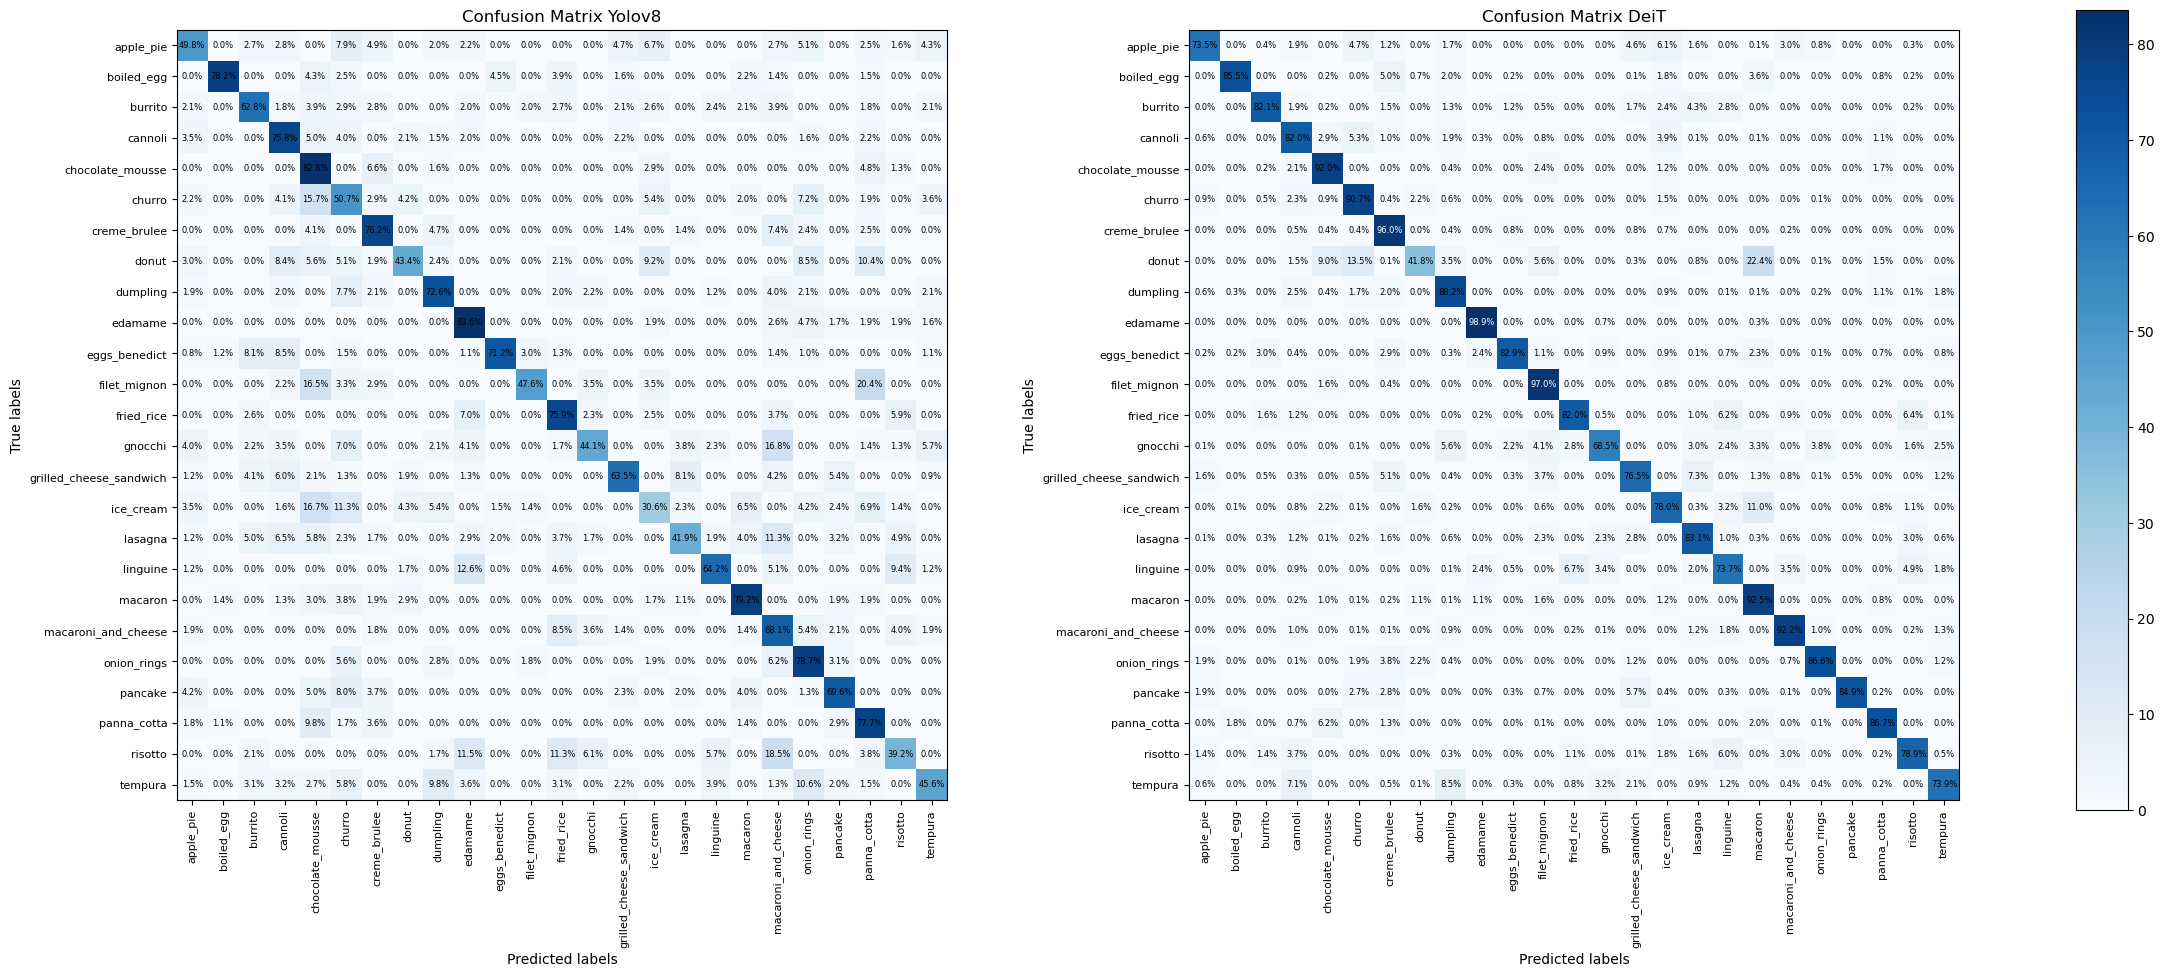

In [119]:
# Create function to create normalized confusion matrix: 
def create_normy_confusion_matrix(df): 
    # Create a confusion matrix using the confidence values
    cm = np.zeros((len(np.unique(df['True Class'])), len(np.unique(df['Predicted Class']))))
    
    for i, true_class in enumerate(np.unique(df['True Class'])):
        for j, predicted_class in enumerate(np.unique(df['Predicted Class'])):
            cm[i, j] = df[(df['True Class'] == true_class) & (df['Predicted Class'] == predicted_class)]['Confidence Value'].sum()
    
    # Normalize the confusion matrix by dividing by the sum of each row
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Multiply by 100 to convert to percentages
    normalized_cm = normalized_cm * 100

    return normalized_cm 

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(26, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.1)

yolo_cm = create_normy_confusion_matrix(yolo_val_results_df)
deit_cm = create_normy_confusion_matrix(deit_val_results_df)

# Create the Yolo heatmap
axs[0].imshow(yolo_cm, interpolation='nearest', cmap='Blues')
axs[0].set_xlabel("Predicted labels")
axs[0].set_ylabel("True labels")
axs[0].set_title("Confusion Matrix Yolov8")
axs[0].set_xticks(range(len(np.unique(yolo_val_results_df['Predicted Class']))), np.unique(yolo_val_results_df['Predicted Class']), rotation=90, fontsize=8)
axs[0].set_yticks(range(len(np.unique(yolo_val_results_df['True Class']))), np.unique(yolo_val_results_df['True Class']), fontsize=8)
# Add text to each square of the first heatmap
for i in range(yolo_cm.shape[0]):
    for j in range(yolo_cm.shape[1]):
        color = plt.cm.Blues(yolo_cm[i, j] / 100)
        if max(color[:3]) < 0.5:
            axs[0].text(j, i, f"{yolo_cm[i, j]:.1f}%", ha="center", va="center", color="white", fontsize=6)
        else:
            axs[0].text(j, i, f"{yolo_cm[i, j]:.1f}%", ha="center", va="center", color="black", fontsize=6)

# Create the DeiT heatmap 
axs[1].imshow(deit_cm, interpolation='nearest', cmap='Blues')
axs[1].set_xlabel("Predicted labels")
axs[1].set_ylabel("True labels")
axs[1].set_title("Confusion Matrix DeiT")
axs[1].set_xticks(range(len(np.unique(deit_val_results_df['Predicted Class']))), np.unique(deit_val_results_df['Predicted Class']), rotation=90, fontsize=8)
axs[1].set_yticks(range(len(np.unique(deit_val_results_df['True Class']))), np.unique(deit_val_results_df['True Class']), fontsize=8)
# Add text to each square of the second heatmap
for i in range(deit_cm.shape[0]):
    for j in range(deit_cm.shape[1]):
        color = plt.cm.Blues(deit_cm[i, j] / 100)
        if max(color[:3]) < 0.5:
            axs[1].text(j, i, f"{deit_cm[i, j]:.1f}%", ha="center", va="center", color="white", fontsize=6)
        else:
            axs[1].text(j, i, f"{deit_cm[i, j]:.1f}%", ha="center", va="center", color="black", fontsize=6)

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
plt.colorbar(axs[0].images[0], cax=cbar_ax)

plt.savefig('confusion_matrices.png', bbox_inches='tight', pad_inches=0.5, dpi=600)